# Data Loading & Handling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from optuna.samplers import TPESampler
from sklearn.tree import plot_tree
from scipy.signal import spectrogram
import glob
import time
from scipy import signal
import wfdb
import os
import pywt 
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch

sns.set(style = 'whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA_PATH = '/Users/ahmedelattar/Documents/Artificial Intelligence/Machine_Learning_Modeling/Heartbeat Classification/Data/mitdb'

FS = 360 

# (The AAMI Standard Classes)
# N: Non-ectopic (Normal)
# S: Supraventricular ectopic
# V: Ventricular ectopic
# F: Fusion
# Q: Unknown
AAMI_CLASSES = {
    'N': ['N', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q']
}

def get_aami_label(original_symbol):
    for key, values in AAMI_CLASSES.items():
        if original_symbol in values:
            return key
    return None  

print("System Initialized. AAMI Classes Defined.")
print(f"Data Directory: {DATA_PATH}")

System Initialized. AAMI Classes Defined.
Data Directory: /Users/ahmedelattar/Documents/Artificial Intelligence/Machine_Learning_Modeling/Heartbeat Classification/Data/mitdb


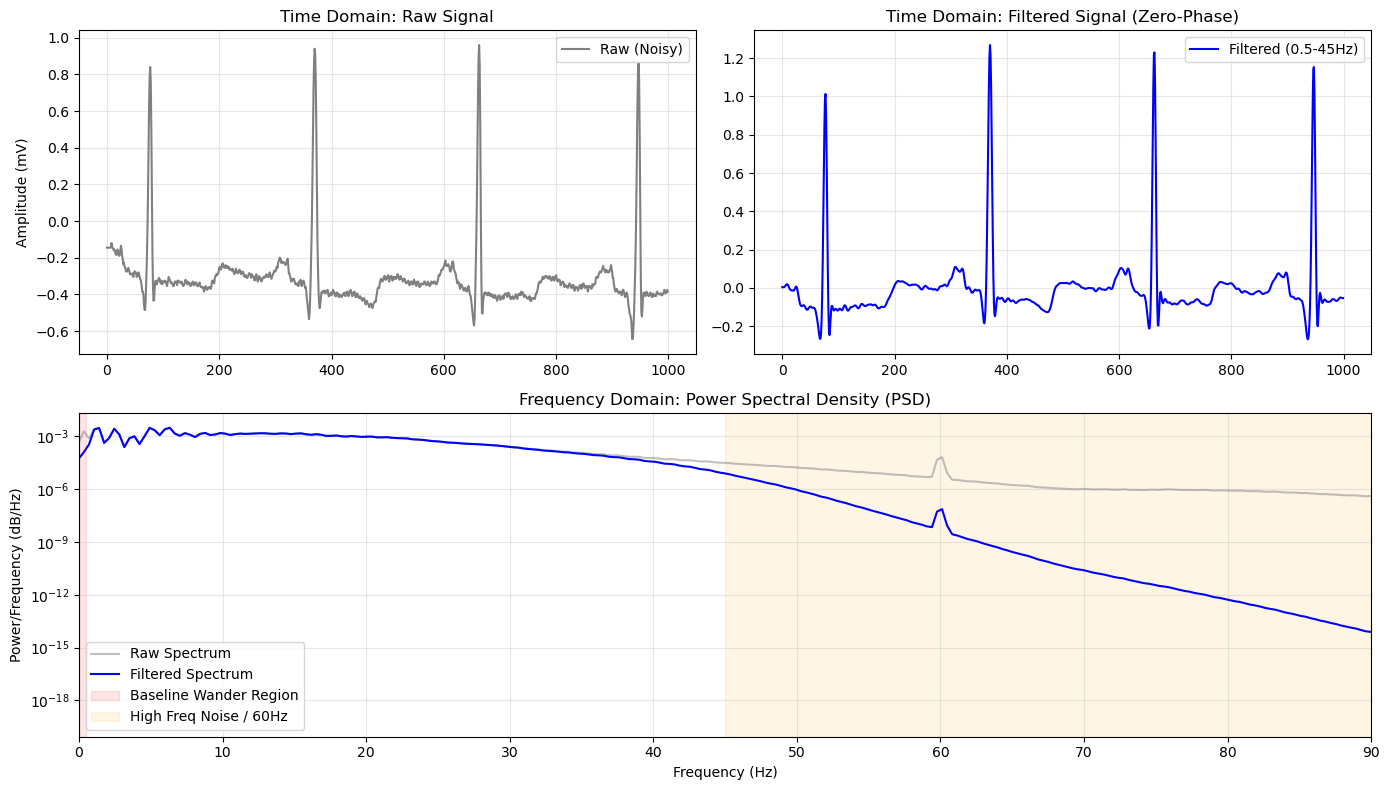

DSP Preprocessing verification complete.


In [ ]:
def get_psd(x, fs):
    """
    Compute Power Spectral Density using Welch's method.
    Useful for visualizing noise in Frequency Domain.
    """
    f, Pxx = signal.welch(x, fs, nperseg=1024)
    return f, Pxx

def preprocess_signal(raw_signal, fs, low_cut=0.5, high_cut=45.0, order=5):
    """
    Apply Zero-Phase Butterworth Bandpass Filter.
    
    Why filtfilt?
    To ensure Zero-Phase distortion, critical for biomedical signal morphology.
    """
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    
    b, a = signal.butter(order, [low, high], btype='band')
    
    clean_signal = signal.filtfilt(b, a, raw_signal)
    
    return clean_signal

try:
    test_record = wfdb.rdrecord(os.path.join(DATA_PATH, '100'))
    raw_sig = test_record.p_signal[:, 0]
    
    clean_sig = preprocess_signal(raw_sig, FS)
    
    f_raw, p_raw = get_psd(raw_sig, FS)
    f_clean, p_clean = get_psd(clean_sig, FS)

    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(raw_sig[:1000], 'gray', label='Raw (Noisy)')
    plt.title("Time Domain: Raw Signal")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(clean_sig[:1000], 'b', label='Filtered (0.5-45Hz)')
    plt.title("Time Domain: Filtered Signal (Zero-Phase)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.semilogy(f_raw, p_raw, 'gray', alpha=0.5, label='Raw Spectrum')
    plt.semilogy(f_clean, p_clean, 'b', linewidth=1.5, label='Filtered Spectrum')
    
    plt.axvspan(0, 0.5, color='red', alpha=0.1, label='Baseline Wander Region')
    plt.axvspan(45, 180, color='orange', alpha=0.1, label='High Freq Noise / 60Hz')
    
    plt.title("Frequency Domain: Power Spectral Density (PSD)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.xlim(0, 90) 
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("DSP Preprocessing verification complete.")

except Exception as e:
    print(f"Error: {e}")

Plotting Spectrogram for the first 10 seconds...


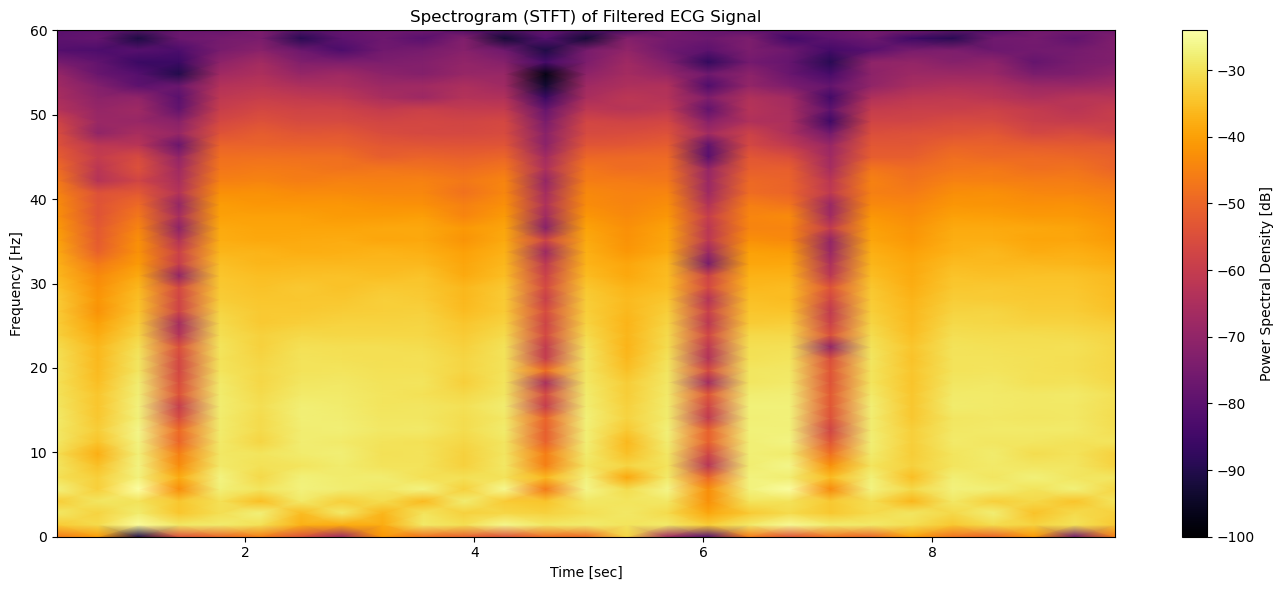

In [ ]:
def plot_spectrogram(signal_data, fs):
    """
    Computes and visualizes the Short-Time Fourier Transform (Spectrogram).
    Useful for analyzing Non-stationary signals like ECG.
    """

    f, t, Sxx = spectrogram(signal_data, fs, nperseg=256, noverlap=128)
    
    plt.figure(figsize=(14, 6))
    
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='inferno')
    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram (STFT) of Filtered ECG Signal')
    
    plt.ylim(0, 60)
    
    cbar = plt.colorbar()
    cbar.set_label('Power Spectral Density [dB]')
    
    plt.tight_layout()
    plt.show()

try:
    segment_length = 10 * FS 
    if len(clean_sig) > segment_length:
        print("Plotting Spectrogram for the first 10 seconds...")
        plot_spectrogram(clean_sig[:segment_length], FS)
    else:
        print("Signal too short, plotting all...")
        plot_spectrogram(clean_sig, FS)

except NameError:
    print("Error: Please run the Preprocessing code block first to define 'clean_sig'.")
except Exception as e:
    print(f"Error: {e}")

Extraction successful!
Total beats extracted from Record 100: 2271
First beat label: N


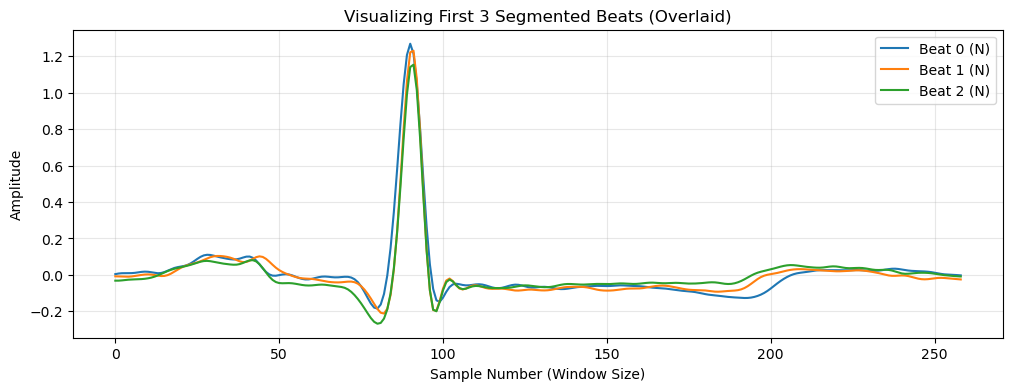

In [ ]:
def segment_beats(record_name, clean_signal, annotation_data, fs):
    """
    Extracts individual heartbeats based on annotation indices.
    
    Parameters:
    - record_name: ID of the patient (for tracking)
    - clean_signal: The filtered ECG signal
    - annotation_data: The wfdb annotation object
    - fs: Sampling frequency
    
    Returns:
    - beats_list: List of dictionaries (waveform, label, original_symbol)
    """

    win_pre = int(0.25 * fs)  
    win_post = int(0.47 * fs) 
    
    extracted_beats = []
    
    r_peaks = annotation_data.sample
    symbols = annotation_data.symbol
    
    for i, r_peak in enumerate(r_peaks):
        original_symbol = symbols[i]
        
        label = get_aami_label(original_symbol)
        
        if label is None:
            continue
            
        if r_peak - win_pre < 0 or r_peak + win_post >= len(clean_signal):
            continue
            
        segment = clean_signal[r_peak - win_pre : r_peak + win_post]
        
        extracted_beats.append({
            'Record_ID': record_name,
            'Signal': segment,       
            'Label': label,         
            'Symbol': original_symbol
        })
        
    return extracted_beats

try:
    record_path = os.path.join(DATA_PATH, '100')
    test_record = wfdb.rdrecord(record_path)
    test_annotation = wfdb.rdann(record_path, 'atr')
    
    clean_sig = preprocess_signal(test_record.p_signal[:, 0], FS)
    
    my_beats = segment_beats('100', clean_sig, test_annotation, FS)
    
    print(f"Extraction successful!")
    print(f"Total beats extracted from Record 100: {len(my_beats)}")
    print(f"First beat label: {my_beats[0]['Label']}")
    
    plt.figure(figsize=(12, 4))
    
    for i in range(3):
        plt.plot(my_beats[i]['Signal'], label=f"Beat {i} ({my_beats[i]['Label']})")
        
    plt.title("Visualizing First 3 Segmented Beats (Overlaid)")
    plt.xlabel("Sample Number (Window Size)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [ ]:
def extract_features(beat_signal, rr_interval, fs=360):
    """
    Extracts a comprehensive set of features from a single heartbeat segment.
    Domains: Time, Frequency, and Wavelet (Time-Frequency).
    
    Parameters:
    - beat_signal: numpy array of the segmented signal
    - rr_interval: The time difference between this beat and the previous one
    - fs: Sampling frequency
    
    Returns:
    - features: Dictionary containing all extracted features
    """
    features = {}
    
    features['T_Mean'] = np.mean(beat_signal)
    features['T_Std'] = np.std(beat_signal)
    features['T_Max'] = np.max(beat_signal)
    features['T_Min'] = np.min(beat_signal)
    
    features['T_Skew'] = skew(beat_signal)
    
    features['T_Kurtosis'] = kurtosis(beat_signal)
    
    features['T_RMS'] = np.sqrt(np.mean(beat_signal**2))
    
    features['T_ZeroCross'] = ((beat_signal[:-1] * beat_signal[1:]) < 0).sum()
    
    features['RR_Interval'] = rr_interval

    f_vals, psd_vals = welch(beat_signal, fs, nperseg=len(beat_signal))
    
    features['F_TotalPower'] = np.sum(psd_vals)
    
    features['F_Peak_Freq'] = f_vals[np.argmax(psd_vals)]
    
    features['F_Power_VLF'] = np.sum(psd_vals[(f_vals >= 0) & (f_vals < 5)])
    features['F_Power_LF'] = np.sum(psd_vals[(f_vals >= 5) & (f_vals < 15)])
    features['F_Power_HF'] = np.sum(psd_vals[(f_vals >= 15) & (f_vals < 40)])
    
    if features['F_Power_LF'] > 0:
        features['F_HF_LF_Ratio'] = features['F_Power_HF'] / features['F_Power_LF']
    else:
        features['F_HF_LF_Ratio'] = 0

    coeffs = pywt.wavedec(beat_signal, 'db4', level=3)
    
    features['W_cA3_Energy'] = np.sum(coeffs[0]**2)
    features['W_cA3_Mean'] = np.mean(coeffs[0])
    
    features['W_cD3_Energy'] = np.sum(coeffs[1]**2)
    features['W_cD3_Mean'] = np.mean(coeffs[1])
    
    features['W_cD2_Energy'] = np.sum(coeffs[2]**2)
    features['W_cD2_Mean'] = np.mean(coeffs[2])

    features['W_cD1_Energy'] = np.sum(coeffs[3]**2)
    features['W_cD1_Mean'] = np.mean(coeffs[3])
    
    energies = [np.sum(c**2) for c in coeffs]
    total_energy = sum(energies)
    if total_energy > 0:
        norm_energies = [e/total_energy for e in energies]
        features['W_Entropy'] = entropy(norm_energies)
    else:
        features['W_Entropy'] = 0

    return features

try:
    test_beat_signal = my_beats[0]['Signal']
    
    test_rr = 0.8 
    
    single_beat_features = extract_features(test_beat_signal, test_rr, FS)
    
    print("Feature Extraction Successful!")
    print(f"Number of extracted features per beat: {len(single_beat_features)}")
    print("\nSample Features (First 10):")
    for k, v in list(single_beat_features.items())[:10]:
        print(f"{k}: {v:.4f}")

except NameError:
    print("Error: 'my_beats' list not found. Run the Segmentation block first.")
except Exception as e:
    print(f"Error: {e}")

Feature Extraction Successful!
Number of extracted features per beat: 24

Sample Features (First 10):
T_Mean: 0.0116
T_Std: 0.1962
T_Max: 1.2687
T_Min: -0.1848
T_Skew: 4.5788
T_Kurtosis: 23.0034
T_RMS: 0.1966
T_ZeroCross: 7.0000
RR_Interval: 0.8000
F_TotalPower: 0.0447


In [ ]:
print("Starting Batch Processing for all MIT-BIH records...")
start_time = time.time()

record_files = glob.glob(os.path.join(DATA_PATH, "*.dat"))
record_ids = [os.path.basename(f).split('.')[0] for f in record_files]
record_ids.sort() 

all_data = []

errors = 0

for record_id in record_ids:
    print(f"Processing Record: {record_id}...", end=" ")
    
    try:
        record_path = os.path.join(DATA_PATH, record_id)
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        
        raw_signal = record.p_signal[:, 0]
        clean_signal = preprocess_signal(raw_signal, FS)
        
        r_peaks = annotation.sample
        rr_intervals = np.diff(r_peaks) / FS
        
        for i in range(1, len(r_peaks) - 1):
            
            current_peak = r_peaks[i]
            original_symbol = annotation.symbol[i]
            current_rr = rr_intervals[i-1] 
            
            label = get_aami_label(original_symbol)
            if label is None: continue 
            
            win_pre = int(0.25 * FS)
            win_post = int(0.47 * FS)
            
            if current_peak - win_pre < 0 or current_peak + win_post >= len(clean_signal):
                continue
            
            segment = clean_signal[current_peak - win_pre : current_peak + win_post]
            
            beat_features = extract_features(segment, current_rr, FS)
            
            beat_features['Label'] = label              
            beat_features['Original_Symbol'] = original_symbol
            beat_features['Record_ID'] = record_id
            
            all_data.append(beat_features)
            
        print(f"Done. (Extracted {len(r_peaks)} beats)")

    except Exception as e:
        print(f"FAILED! Error: {e}")
        errors += 1

final_df = pd.DataFrame(all_data)

cols = ['Record_ID', 'Label', 'Original_Symbol'] + [c for c in final_df.columns if c not in ['Record_ID', 'Label', 'Original_Symbol']]
final_df = final_df[cols]

output_csv = 'ECG_Features_Dataset.csv'
final_df.to_csv(output_csv, index=False)

end_time = time.time()
print("\n" + "="*40)
print(f"PIPELINE COMPLETED in {end_time - start_time:.2f} seconds.")
print(f"Total Records Processed: {len(record_ids)}")
print(f"Total Beats Extracted: {len(final_df)}")
print(f"Dataset Saved to: {output_csv}")
print("="*40)

print("\nClass Distribution (AAMI Standards):")
print(final_df['Label'].value_counts())

Starting Batch Processing for all MIT-BIH records...
Processing Record: 100... Done. (Extracted 2274 beats)
Processing Record: 101... Done. (Extracted 1874 beats)
Processing Record: 102... Done. (Extracted 2192 beats)
Processing Record: 103... Done. (Extracted 2091 beats)
Processing Record: 104... Done. (Extracted 2311 beats)
Processing Record: 105... Done. (Extracted 2691 beats)
Processing Record: 106... Done. (Extracted 2098 beats)
Processing Record: 107... Done. (Extracted 2140 beats)
Processing Record: 108... Done. (Extracted 1824 beats)
Processing Record: 109... Done. (Extracted 2535 beats)
Processing Record: 111... Done. (Extracted 2133 beats)
Processing Record: 112... Done. (Extracted 2550 beats)
Processing Record: 113... Done. (Extracted 1796 beats)
Processing Record: 114... Done. (Extracted 1890 beats)
Processing Record: 115... Done. (Extracted 1962 beats)
Processing Record: 116... Done. (Extracted 2421 beats)
Processing Record: 117... Done. (Extracted 1539 beats)
Processing R

In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109432 entries, 0 to 109431
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Record_ID        109432 non-null  object 
 1   Label            109432 non-null  object 
 2   Original_Symbol  109432 non-null  object 
 3   T_Mean           109432 non-null  float64
 4   T_Std            109432 non-null  float64
 5   T_Max            109432 non-null  float64
 6   T_Min            109432 non-null  float64
 7   T_Skew           109432 non-null  float64
 8   T_Kurtosis       109432 non-null  float64
 9   T_RMS            109432 non-null  float64
 10  T_ZeroCross      109432 non-null  int64  
 11  RR_Interval      109432 non-null  float64
 12  F_TotalPower     109432 non-null  float64
 13  F_Peak_Freq      109432 non-null  float64
 14  F_Power_VLF      109432 non-null  float64
 15  F_Power_LF       109432 non-null  float64
 16  F_Power_HF       109432 non-null  floa

In [64]:
df = final_df.copy() 
le = LabelEncoder()
y_raw = df['Label']

X = df.drop(['Label', 'Record_ID', 'Original_Symbol'], axis = 1)
y = le.fit_transform(y_raw)

In [65]:
print("Classes found:", le.classes_)

label_mapping = dict(zip(range(len(le.classes_)), le.classes_))

print("\n--- Target Mapping Keys ---")
for code, label in label_mapping.items():
    print(f"Code {code} = {label}")

Classes found: ['F' 'N' 'Q' 'S' 'V']

--- Target Mapping Keys ---
Code 0 = F
Code 1 = N
Code 2 = Q
Code 3 = S
Code 4 = V


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [67]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
def objective_dt(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 21),   
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_float('max_features', 0.2, 1.0),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.005)

        
    }

    model = DecisionTreeClassifier(**param, random_state = 42)

    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy')
    
    return scores.mean()

In [69]:
print("--- Start Tuning Decision Tree ---")
study_dt = optuna.create_study(sampler = TPESampler(seed = 41), direction = 'maximize') 
study_dt.optimize(objective_dt, n_trials = 30) 
best_params_dt = study_dt.best_params
print("Best DT Params:", best_params_dt)

[I 2025-12-09 10:03:21,829] A new study created in memory with name: no-name-88930a18-c6de-411b-b96b-0056d3eb99b6


--- Start Tuning Decision Tree ---


[I 2025-12-09 10:03:28,784] Trial 0 finished with value: 0.9593808898280883 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy', 'max_features': 0.6830925511590505, 'ccp_alpha': 0.0009546533138986957}. Best is trial 0 with value: 0.9593808898280883.
[I 2025-12-09 10:03:33,012] Trial 1 finished with value: 0.9348335141927009 and parameters: {'max_depth': 37, 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini', 'max_features': 0.34902581391857956, 'ccp_alpha': 0.0015855523524331532}. Best is trial 0 with value: 0.9593808898280883.
[I 2025-12-09 10:03:38,039] Trial 2 finished with value: 0.9469872636929579 and parameters: {'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'entropy', 'max_features': 0.5185702367065795, 'ccp_alpha': 0.003041132297615244}. Best is trial 0 with value: 0.9593808898280883.
[I 2025-12-09 10:03:42,754] Trial 3 finished with value: 0.9448740647666913 and parameters: {'

Best DT Params: {'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.8388535730561693, 'ccp_alpha': 4.658637349644513e-05}


In [70]:
best_dt = DecisionTreeClassifier(**best_params_dt, random_state = 42)
best_dt.fit(X_train_scaled, y_train)
y_pred_dt = best_dt.predict(X_test_scaled)
acc_dt = accuracy_score(y_test, y_pred_dt)

In [71]:
print(f"Decision Tree Test Accuracy: {acc_dt:.4f}")
class_names = le.inverse_transform(sorted(list(set(y)))) 
print("Classification Report:\n", classification_report(y_test, y_pred_dt, target_names=class_names))

Decision Tree Test Accuracy: 0.9726
Classification Report:
               precision    recall  f1-score   support

           F       0.69      0.65      0.67       172
           N       0.98      0.99      0.99     18110
           Q       0.97      0.95      0.96      1598
           S       0.87      0.73      0.79       560
           V       0.93      0.91      0.92      1447

    accuracy                           0.97     21887
   macro avg       0.89      0.85      0.87     21887
weighted avg       0.97      0.97      0.97     21887



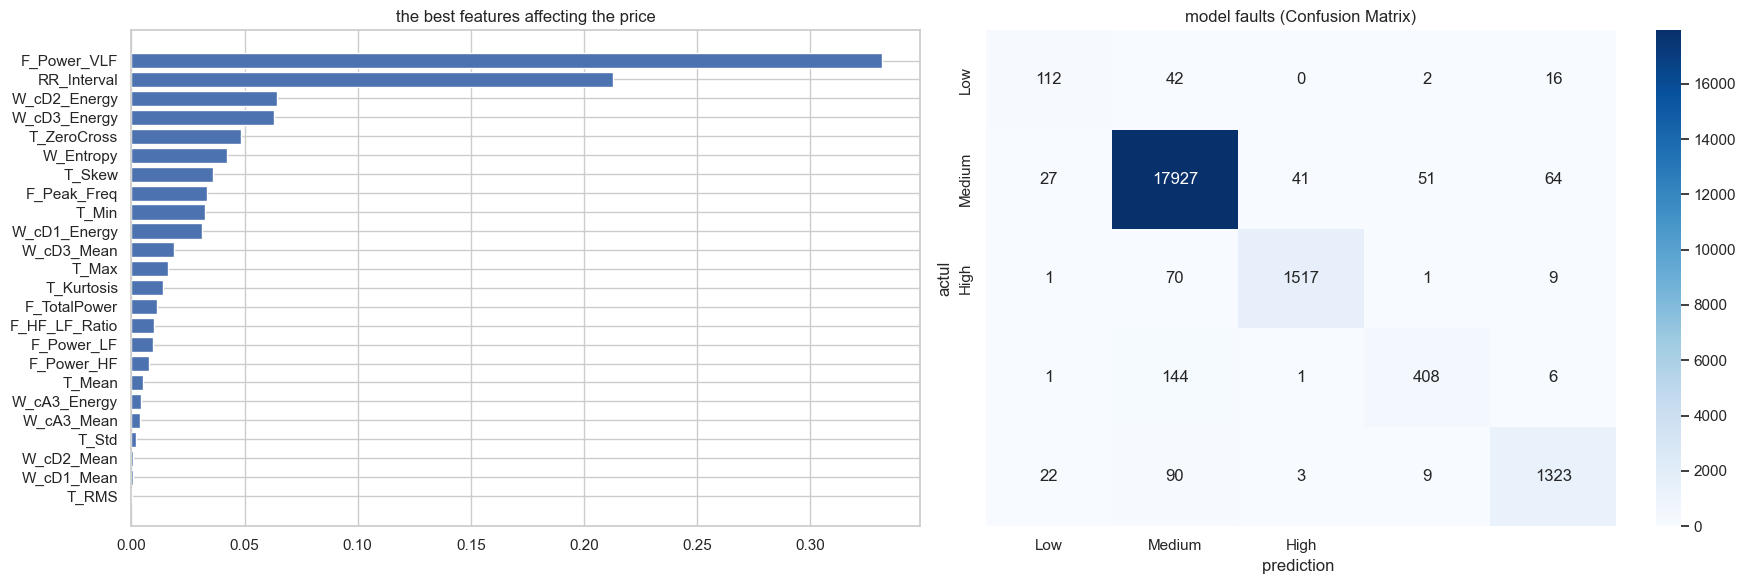

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

importances = best_dt.feature_importances_
names = X.columns
indices = np.argsort(importances)

ax[0].barh(range(len(indices)), importances[indices], color='#4c72b0')
ax[0].set_yticks(range(len(indices)))
ax[0].set_yticklabels(names[indices])
ax[0].set_title('the best features affecting the price')

cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax[1].set_title('model faults (Confusion Matrix)')
ax[1].set_xlabel('prediction ')
ax[1].set_ylabel('actul')

plt.tight_layout()
plt.show()

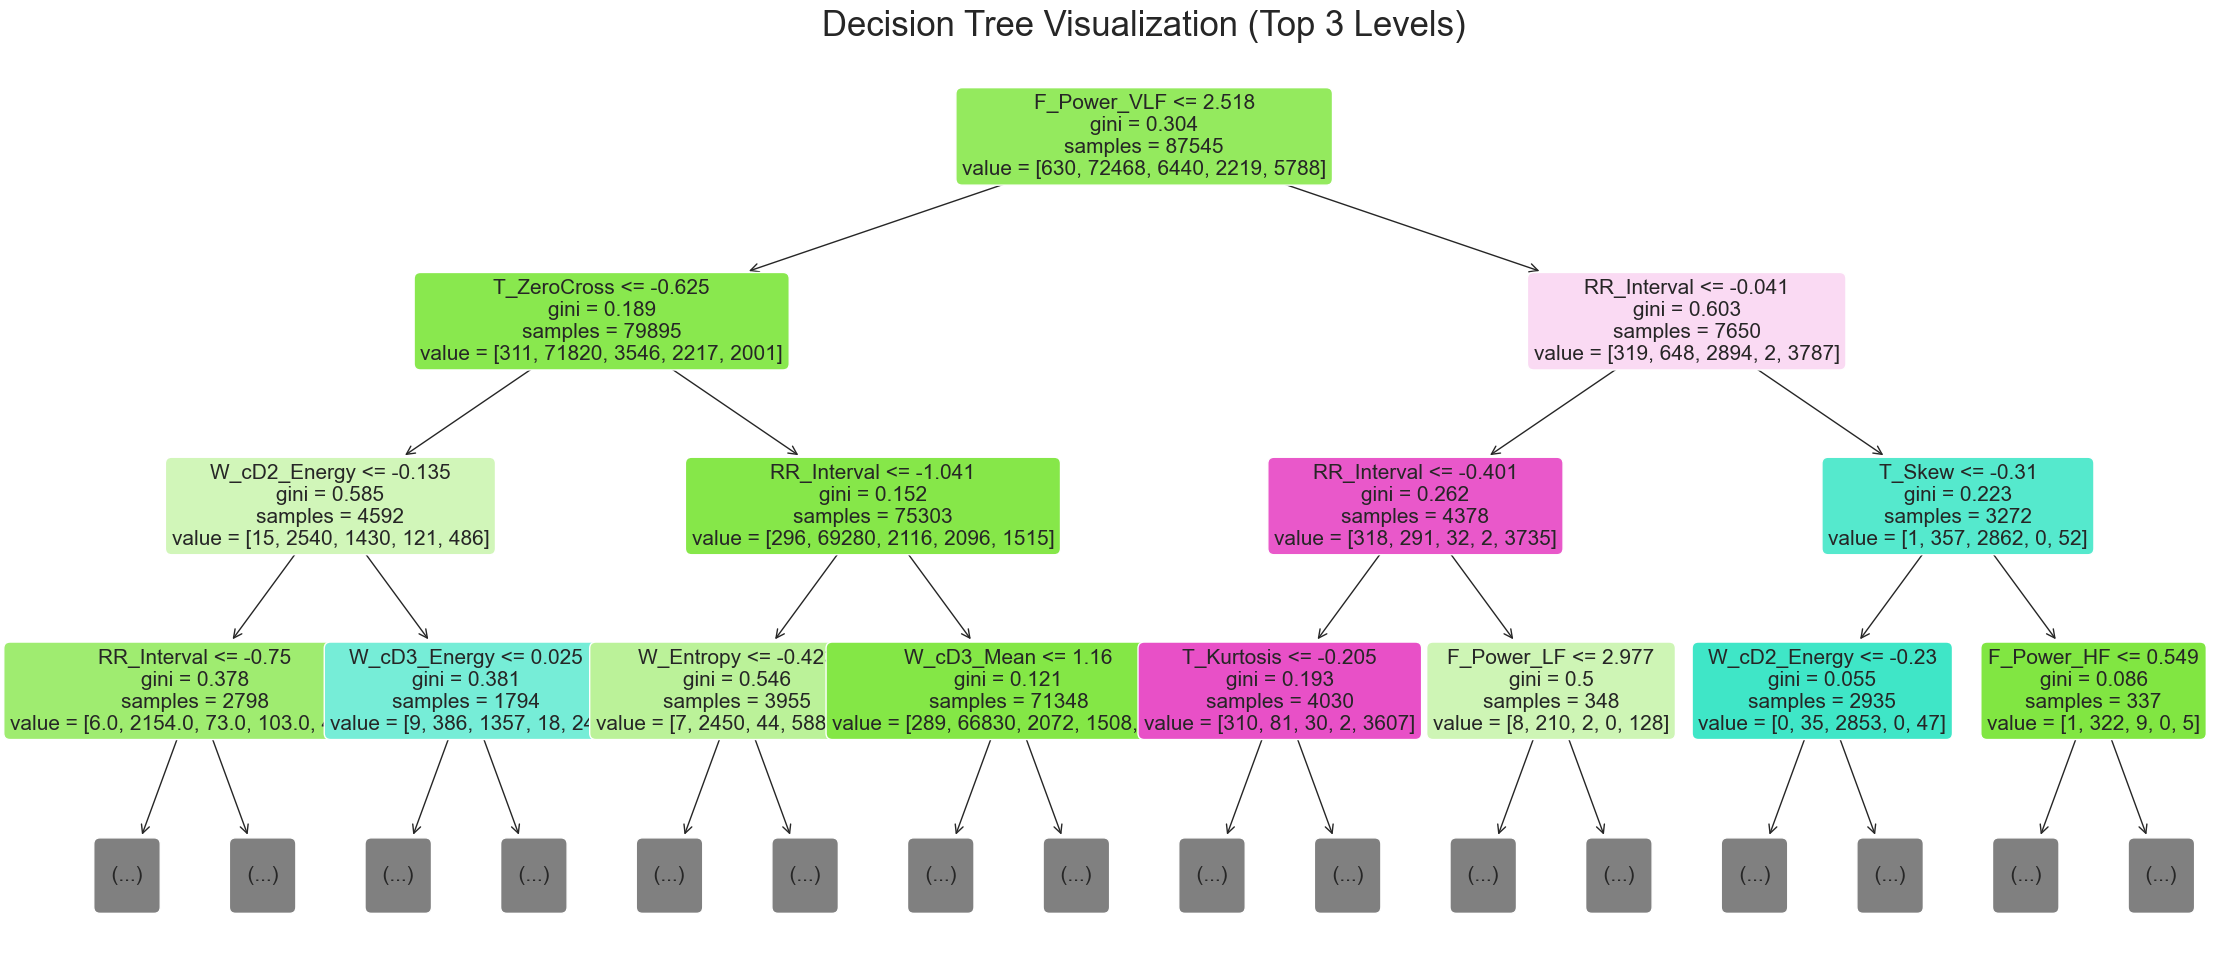

In [42]:
plt.figure(figsize=(28, 12))

plot_tree(
    best_dt,               
    feature_names = X.columns, 
    filled = True,                
    rounded = True,               
    fontsize = 15,               
    max_depth = 3                
)

plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize = 25)
plt.show()